<a href="https://colab.research.google.com/github/sunnyineverywhere/ML_KINML/blob/main/House_Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Evaluating House Prices (via House Prices dataset, Ames, Iowa)

---

## 💻 How to run?

1. Clone this repository  
```bash
  git clone https://github.com/sunnyineverywhere/ML_KINML.git
```
2. Upload `House_Price_Prediction.ipynb` on Colab
3. If Step 1 or Step 2 is impossible, just click above `open in colab` button
4. Click `Runtime` `Run all(모두실행)`

  
## 👏 Project Info
> In this project, we predict house prices with Machine Learning Algorithm. We tested Linaer Regression, LightGBM, Random Forest, XGBoost.   

> By measuring propagation with mae & rmae, we found that lightGBM is the best model for our project.  

> This project is uploaded in [Kaggle Competition](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques) and we ranked 949th.
![image](https://user-images.githubusercontent.com/80109963/208233320-60d2813e-c965-4515-83fa-1ba41b9bc8cf.png)

<br />

## 🎮 TEAM KINML Members
<table border="1" cellspacing="0" cellpadding="0" width="90%">
    <tr width="100%">
        <td width="20%" align="center"><a href= "https://github.com/">Hyunjung Park</a></td>
        <td width="20%" align="center"><a href= "https://github.com/
yekim8">Yeongeun Kim</a></td>
        <td width="20%" align="center"><a href= "https://github.com/sunnyineverywhere">Seon UI Lee</a></td>
        <td width="20%" align="center"><a href= "https://github.com/win2dvp21">Seungyoun Lee</a></td>
        <td width="20%" align="center"><a href= "https://github.com/whazek">Yunju Jang</a></td>
    </tr>
    <tr width="100%">
        <td width="20%" align="center"><img src = "https://github.com/github.png"></td>
        <td width="20%" align="center"><img src = "https://github.com/yekim8.png"/></td>
        <td width="20%" align="center"><img src = "https://github.com/sunnyineverywhere.png"/></td>
        <td width="20%" align="center"><img src = "https://github.com/win2dvp21.png"/></td>
        <td width="20%" align="center"><img src = "https://github.com/whazek.png"/></td>
    </tr>
    <tr width="100%">
        <td width="20%" align="center">Linear Regression</td>
        <td width="20%" align="center">lightGBM</td>
        <td width="20%" align="center">Random Forest</td>
        <td width="20%" align="center">lightGBM</td>
        <td width="20%" align="center">XGBoost</td>
   </tr>
</table>

# Model & Scores
---

<br />

<table border="1" cellspacing="0" cellpadding="0" width="90%">
    <tr width="100%">
        <td width="20%" align="center">Score</td>
        <td width="20%" align="center">XGB</td>
        <td width="20%" align="center">lightGBM</td>
        <td width="20%" align="center">Random Forest</td>
        <td width="20%" align="center">Linear Comparison(Lasso)</td>
    </tr>
    <tr width="100%">
        <td width="20%" align="center">train mae score</td>
        <td width="20%" align="center">0.0468</td>
        <td width="20%" align="center">0.0489</td>
        <td width="20%" align="center">0.0352</td>
        <td width="20%" align="center"></td>
    </tr>
    <tr width="100%">
        <td width="20%" align="center">val mae score</td>
        <td width="20%" align="center">0.0805</td>
        <td width="20%" align="center">0.0816</td>
        <td width="20%" align="center">0.0967</td>
        <td width="20%" align="center">0.0822</td>
    </tr>
    <tr width="100%">
        <td width="20%" align="center">train rmse score</td>
        <td width="20%" align="center">0.0650</td>
        <td width="20%" align="center">0.0680</td>
        <td width="20%" align="center">0.0510</td>
        <td width="20%" align="center"></td>
    </tr>
    <tr width="100%">
        <td width="20%" align="center">val rmse score</td>
        <td width="20%" align="center">0.1162</td>
        <td width="20%" align="center">0.1146</td>
        <td width="20%" align="center">0.1404</td>
        <td width="20%" align="center">0.1145</td>
    </tr>
</table>

## 1. Import Data

In [ ]:
import numpy as np
import pandas as pd

from scipy import stats
from scipy.stats import norm, skew #for some statistics

!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=15nk00lZXpCiOPXAtpkBoT7RdmRyCCq_U' -O test.csv
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1uDTPwWIAays7N7zY4113_Mygr5zJ2jWC' -O train.csv

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

--2022-12-08 01:44:44--  https://docs.google.com/uc?export=download&id=15nk00lZXpCiOPXAtpkBoT7RdmRyCCq_U
Resolving docs.google.com (docs.google.com)... 142.250.107.138, 142.250.107.102, 142.250.107.100, ...
Connecting to docs.google.com (docs.google.com)|142.250.107.138|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-08-80-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/38q711ki4pbnqb49dqb2q47284864g41/1670463825000/14827738442420886269/*/15nk00lZXpCiOPXAtpkBoT7RdmRyCCq_U?e=download&uuid=8beef82b-25a1-4854-9bc2-62a2f2c1a596 [following]
--2022-12-08 01:44:44--  https://doc-08-80-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/38q711ki4pbnqb49dqb2q47284864g41/1670463825000/14827738442420886269/*/15nk00lZXpCiOPXAtpkBoT7RdmRyCCq_U?e=download&uuid=8beef82b-25a1-4854-9bc2-62a2f2c1a596
Resolving doc-08-80-docs.googleusercontent.com (doc-08-80-docs.googleusercontent.com)... 74.125.20.132, 2607:f8

### 1-1. Remove Outliers

In [ ]:
#아웃라이어 제거
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)
#ID 제거
train.drop(['Id'], axis = 1, inplace = True)
test.drop(['Id'], axis = 1, inplace = True)

## 2. Get the fitted parameters using normalization function

In [ ]:
# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['SalePrice'])
print( 'mu = {:.2f} and sigma = {:.2f}'.format(mu, sigma))

# We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
train["SalePrice"] = np.log1p(train["SalePrice"])

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['SalePrice'])
print( 'mu = {:.2f} and sigma = {:.2f}'.format(mu, sigma))

mu = 180932.92 and sigma = 79467.79
mu = 12.02 and sigma = 0.40


In [ ]:
import matplotlib.pyplot as plt
# vNd = np.random.normal(50, 10, 1000)
# plt.hist(vNd, 100)
# plt.show()

## 3. Data PreProcessing
---

### 3-1. Merging data

In [ ]:
#데이터 합침
ntrain = train.shape[0]
ntrain = int(ntrain * 0.8)
#ntest = train.shape[ntrain:]
y_train = train[:ntrain].SalePrice.values
y_test = train[ntrain:].SalePrice.values

#all_data = pd.concat((train, test)).reset_index(drop=True)
all_data = train
all_data.drop(['SalePrice'], axis=1, inplace=True)
print("all_data size is : {}".format(all_data.shape))

all_data size is : (1458, 79)


### 3-2. Remove Null values

In [ ]:
#NULL 값 처리
all_data["PoolQC"] = all_data["PoolQC"].fillna("None")
all_data["MiscFeature"] = all_data["MiscFeature"].fillna("None")
all_data["Alley"] = all_data["Alley"].fillna("None")
all_data["Fence"] = all_data["Fence"].fillna("None")
all_data["FireplaceQu"] = all_data["FireplaceQu"].fillna("None")
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))

for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
  all_data[col] = all_data[col].fillna('None')

for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
  all_data[col] = all_data[col].fillna(0)

for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
  all_data[col] = all_data[col].fillna(0)

for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
  all_data[col] = all_data[col].fillna('None')

all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)

all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])

all_data = all_data.drop(['Utilities'], axis=1)

all_data["Functional"] = all_data["Functional"].fillna("Typ")

all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])

all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])

all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])

all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])

all_data['MSSubClass'] = all_data['MSSubClass'].fillna("None")

### 3-3. Check Remaining Null Data

In [ ]:
#Check remaining missing values if any 
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head()

,Missing Ratio


### 3-4. Data Processing
- LabelEncorder
- Check the **skew** of all numerical features

In [ ]:
#MSSubClass=The building class
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)

#Changing OverallCond into a categorical variable
all_data['OverallCond'] = all_data['OverallCond'].astype(str)

#Year and month sold are transformed into categorical features.
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

In [ ]:
from sklearn.preprocessing import LabelEncoder
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')

# process columns, apply LabelEncoder to categorical features
for c in cols:
  lbl = LabelEncoder() 
  lbl.fit(list(all_data[c].values)) 
  all_data[c] = lbl.transform(list(all_data[c].values))

# shape        
print('Shape all_data: {}'.format(all_data.shape))

Shape all_data: (1458, 78)


In [ ]:
from scipy.stats import skew
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)


Skew in numerical features: 



,Skew
MiscVal,24.434913
PoolArea,15.932532
LotArea,12.560986
3SsnPorch,10.286510
LowQualFinSF,8.995688
LandSlope,4.805032
KitchenAbvGr,4.480268
BsmtFinSF2,4.247550
ScreenPorch,4.114690
BsmtHalfBath,4.095895


In [ ]:
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
  #all_data[feat] += 1
  all_data[feat] = boxcox1p(all_data[feat], lam)

There are 58 skewed numerical features to Box Cox transform


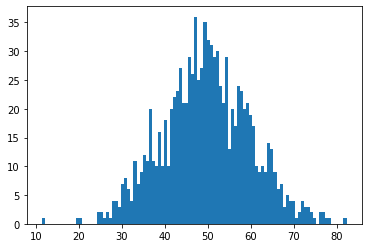

In [ ]:
vNd = np.random.normal(50, 10, 1000)
plt.hist(vNd, 100)
plt.show()

### 3-5. Split Data into train & test 

In [ ]:
all_data = pd.get_dummies(all_data)

train = all_data[:ntrain]
test = all_data[ntrain:]


## 4. LightGBM Model
---

In [ ]:
from sklearn.model_selection import KFold, cross_val_score, train_test_split
import lightgbm as lgb
from sklearn.metrics import mean_squared_error

In [ ]:
n_folds = 5

def rmsle_cv(model):
  kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
  rmse= np.sqrt(-cross_val_score(model, train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
  return(rmse)

In [ ]:
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)
score = rmsle_cv(model_lgb)
print("LGBM score: {:.4f} ({:.4f})" .format(score.mean(), score.std()))

LGBM score: 0.1214 (0.0070)


In [ ]:
from sklearn.model_selection import GridSearchCV
param = {
    'max_depth':[2,3,4],
    'n_estimators':range(550,700,50),
    'colsample_bytree':[0.5,0.7,1],
    'colsample_bylevel':[0.5,0.7,1],
}

model_lgb2 = lgb.LGBMRegressor(objective='regression')
grid_search = GridSearchCV(estimator=model_lgb2, param_grid=param, cv=3, refit = True)

grid_search.fit(train, y_train)
#grid_search.cv_results_["params"]
grid_search.cv_results_["mean_test_score"]

print(grid_search.best_params_)
print(grid_search.best_estimator_)

{'colsample_bylevel': 0.5, 'colsample_bytree': 0.5, 'max_depth': 2, 'n_estimators': 650}
LGBMRegressor(colsample_bylevel=0.5, colsample_bytree=0.5, max_depth=2,
              n_estimators=650, objective='regression')


In [ ]:
model_lgb2 = lgb.LGBMRegressor(objective='regression', colsample_bylevel = 0.5, colsample_bytree = 0.5, max_depth = 2, n_estimators = 650)
model_lgb2.fit(train, y_train)
lgb_train_pred2 = model_lgb2.predict(train)
lgb_pred2 = model_lgb2.predict(test)

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
print('train mae score: ', mean_absolute_error(y_train, lgb_train_pred2))
print('train rmse score: ', math.sqrt(mean_squared_error(y_train, lgb_train_pred2)))
print('val mae score:', mean_absolute_error(y_test, lgb_pred2))
print('val rmse score: ', math.sqrt(mean_squared_error(y_test, lgb_pred2)))

train mae score:  0.04893912441315999
train rmse score:  0.07123142119531198
val mae score: 0.08327122016430434
val rmse score:  0.11656133532066312


In [ ]:
def rmsle(y, y_pred):
  return np.sqrt(mean_squared_error(y, y_pred))

In [ ]:
#y_train = np.expm1(y_train)
#print(y_train)

In [ ]:
#y_train = np.expm1(y_train)
model_lgb.fit(train, y_train)
lgb_train_pred = model_lgb.predict(train)
lgb_train_pred = model_lgb.predict(train)
lgb_pred = model_lgb.predict(test.values)
#y의 값에 로그변환이 되어있기 때문에 expm1 해주면 원래 값으로 변환 가능
#실제 test값을 넣을 때는 expm1을 취해야함
#lgb_pred = model_lgb.predict(test)
print(rmsle(y_train, lgb_train_pred))

0.06803195491695653


In [ ]:
# print(np.round(lgb_pred,3))

In [ ]:
# print(y_test)

In [ ]:
print(ntrain)

1166


### 4-1. LightGBM TEST

In [ ]:
#y_test
print(rmsle(y_test, lgb_pred))

196177.40959018192


### 4-2. LightGBM MAE. & RMSE SCORE

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
print('train mae score: ', mean_absolute_error(y_train, lgb_train_pred))
print('train rmse score: ', math.sqrt(mean_squared_error(y_train, lgb_train_pred)))
#print('val mae score:', mean_absolute_error(y_val, pred_val))

train mae score:  0.048856518468761684
train rmse score:  0.06803195491695653


### 4-3. LightGBM MAE. & RMSE SCORE for test values

In [ ]:
print('val mae score:', mean_absolute_error(y_test, lgb_pred))
print('val rmse score: ', math.sqrt(mean_squared_error(y_test, lgb_pred)))

val mae score: 0.08157040039101501
val rmse score:  0.11462872010515657


### 4-4. LightGBM Prediction Graph

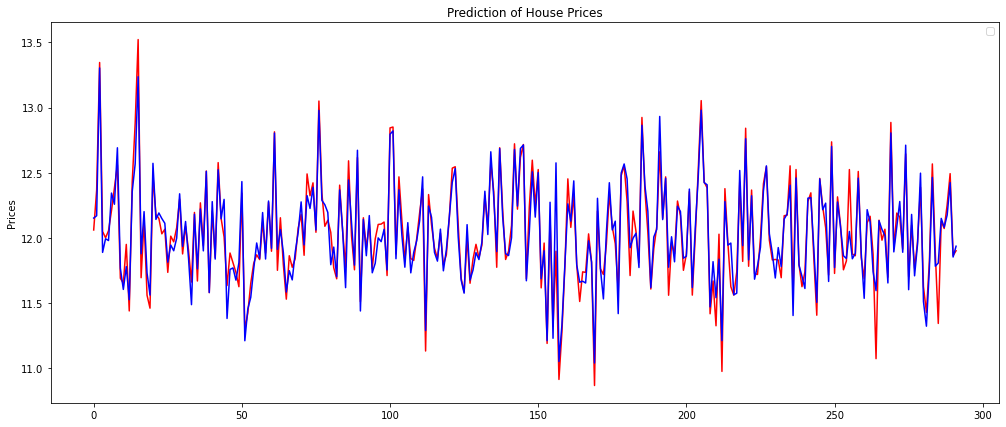

In [ ]:

plt.figure(figsize=(17,7))
plt.plot(y_test, color='red')
plt.plot(lgb_pred2, color='blue')
plt.title('Prediction of House Prices')
plt.ylabel('Prices')
plt.legend()

## 5. XGBoost Model
---

### 5-1. GridSearchCV
> find best parameters

In [ ]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

param = {
    'max_depth':[2,3,4],
    'n_estimators':range(550,700,50),
    'colsample_bytree':[0.5,0.7,1],
    'colsample_bylevel':[0.5,0.7,1],
}
model = xgb.XGBRegressor(objective='reg:squarederror')
grid_search = GridSearchCV(estimator=model, param_grid=param, cv=3, refit = True)

grid_search.fit(train, y_train)
#grid_search.cv_results_["params"]
grid_search.cv_results_["mean_test_score"]

print(grid_search.best_params_)
print(grid_search.best_estimator_)

{'colsample_bylevel': 0.7, 'colsample_bytree': 0.5, 'max_depth': 2, 'n_estimators': 550}
XGBRegressor(colsample_bylevel=0.7, colsample_bytree=0.5, max_depth=2,
             n_estimators=550, objective='reg:squarederror')


### 5-2. XGBoost Model with best parameters

In [ ]:
model = xgb.XGBRegressor(colsample_bylevel=0.5, colsample_bytree=0.5, max_depth=2, n_estimators=550,
             objective='reg:squarederror')
model.fit(train, y_train)
predictions = model.predict(test)
predictions

array([12.123496 , 12.218883 , 13.141196 , 11.8789425, 11.979992 ,
       11.93026  , 12.322665 , 12.260443 , 12.636248 , 11.7926655,
       11.608993 , 11.796035 , 11.467382 , 12.330563 , 12.581539 ,
       13.266789 , 11.887883 , 12.286824 , 11.750883 , 11.5582285,
       12.553931 , 12.151171 , 12.213211 , 11.920581 , 12.096129 ,
       11.795384 , 12.014792 , 11.895292 , 11.990668 , 12.343289 ,
       11.931986 , 12.094286 , 11.841188 , 11.508316 , 12.154539 ,
       11.79632  , 12.249188 , 11.887066 , 12.599665 , 11.593272 ,
       12.221832 , 11.863853 , 12.530964 , 12.205056 , 12.342975 ,
       11.397067 , 11.755692 , 11.764252 , 11.638441 , 11.752497 ,
       12.37141  , 11.303754 , 11.411672 , 11.613958 , 11.809283 ,
       11.964868 , 11.799121 , 12.225796 , 11.851914 , 12.294987 ,
       11.911105 , 12.761445 , 11.89766  , 12.107132 , 11.874191 ,
       11.558708 , 11.795354 , 11.651378 , 11.881752 , 12.033255 ,
       12.301987 , 11.89279  , 12.340248 , 12.236817 , 12.4001

### 5-3. XGBoost MAE & RMSE score

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
pred_train = grid_search.predict(train)
pred_test = grid_search.predict(test)

#print('train acc score: ',accuracy = accuracy_score(y_train, pred_train))
#print('val acc score: ',accuracy = accuracy_score(y_val, pred_val))

print('train mae score: ', mean_absolute_error(y_train, pred_train))
print('val mae score:', mean_absolute_error(y_test,pred_test))

print('train rmse score: ', math.sqrt(mean_squared_error(y_train, pred_train)))
print('val rmse score: ', math.sqrt(mean_squared_error(y_test, pred_test)))

train mae score:  0.04678239313004274
val mae score: 0.08047564632475004
train rmse score:  0.06500606720585027
val rmse score:  0.11621051595424928


### 5-4. XGBoost Prediction Graph  
// TODO: 확인 필요

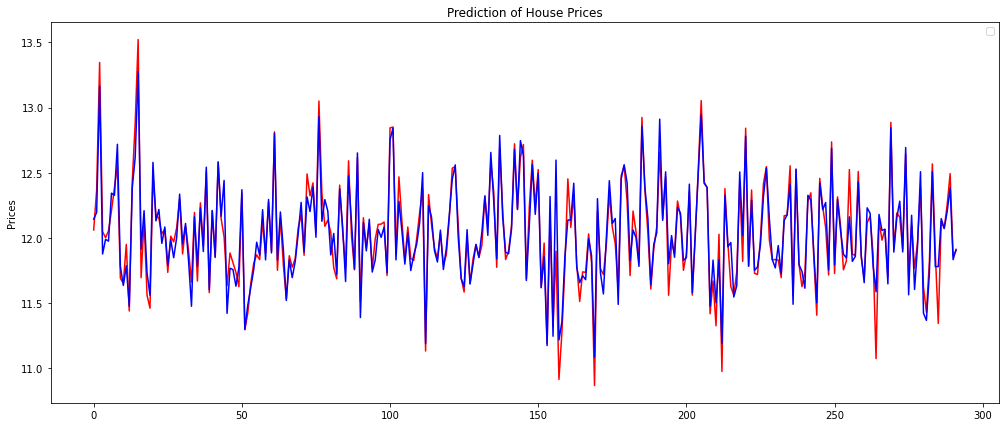

In [ ]:
plt.figure(figsize=(17,7))
plt.plot(y_test, color='red')
plt.plot(pred_test, color='blue')
plt.title('Prediction of House Prices')
plt.ylabel('Prices')
plt.legend()

## 6. Random Forest
---

### 6-1. Random Forest Model

In [ ]:
# Fit Random Forest on Training Set
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
regressor = RandomForestRegressor(n_estimators=300, random_state=0)
regressor.fit(train, y_train)

RandomForestRegressor(n_estimators=300, random_state=0)

### 6-2. Random Forest MAE & RMSE score

In [ ]:
rf_pred_train = regressor.predict(train)
rf_pred_test = regressor.predict(test)

print('train mae score: ', mean_absolute_error(y_train, rf_pred_train))
print('val mae score:', mean_absolute_error(y_test,rf_pred_test))

print('train rmse score: ', math.sqrt(mean_squared_error(y_train, rf_pred_train)))
print('val rmse score: ', math.sqrt(mean_squared_error(y_test, rf_pred_test)))

train mae score:  0.03521599411094773
val mae score: 0.09668601324049388
train rmse score:  0.05104430226193372
val rmse score:  0.14041616265079718


### 6-3. Random Forest Prediction Graph

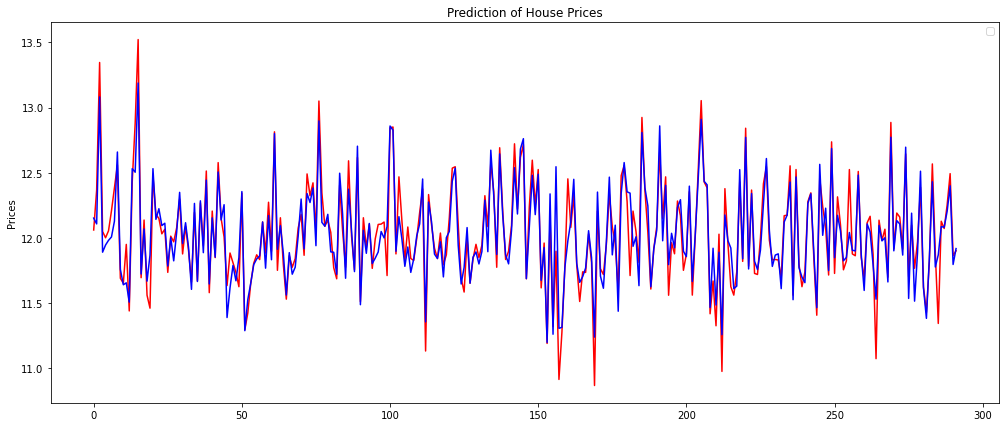

In [ ]:
plt.figure(figsize=(17,7))
plt.plot(y_test, color='red')
plt.plot(rf_pred_test, color='blue')
plt.title('Prediction of House Prices')
plt.ylabel('Prices')
plt.legend()

## 7. Linear Regression

In [ ]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# print best rmse and return best_estimator
def get_best_estimator(model, params):
    grid_model = GridSearchCV(model, param_grid=params, scoring="neg_mean_squared_error", cv=5)
    grid_model.fit(train, y_train)
    rmse = np.sqrt(-1*grid_model.best_score_)
    print('{0}, param:{1}, rmse:{2}'.format(model.__class__.__name__, grid_model.best_params_,\
                                            np.round(rmse, 4)))
    return grid_model.best_estimator_

ridge_params = {'alpha':[0.05, 0.1, 1, 5, 8, 10, 15]}
lasso_params = {'alpha':[0.001, 0.005, 0.008, 0.05, 0.1, 0.3, 0.5, 1, 5, 10]}
elastic_params = {'alpha':[0.05, 0.1, 0.5, 1, 3, 5, 8]}

ridge_reg = Ridge()
lasso_reg = Lasso() 
elastic_reg = ElasticNet(l1_ratio=0.7)

lasso_be = get_best_estimator(lasso_reg, lasso_params)
ridge_be = get_best_estimator(ridge_reg, ridge_params)
elastic_be = get_best_estimator(elastic_reg, elastic_params)

Lasso, param:{'alpha': 0.001}, rmse:0.1189
Ridge, param:{'alpha': 8}, rmse:0.1193
ElasticNet, param:{'alpha': 0.05}, rmse:0.1903


In [ ]:
print('Lasso')
lasso_pred = lasso_be.predict(test)
print('val mae score:', mean_absolute_error(y_test, lasso_pred))
print('val rmse score: ', math.sqrt(mean_squared_error(y_test, lasso_pred)))

Lasso
val mae score: 0.08224327811758474
val rmse score:  0.11449669365412077


In [ ]:
print('Ridge')
ridge_pred = ridge_be.predict(test)
print('val mae score:', mean_absolute_error(y_test, ridge_pred))
print('val rmse score: ', math.sqrt(mean_squared_error(y_test, ridge_pred)))

Ridge
val mae score: 0.08086314914752865
val rmse score:  0.11463261866411448


In [ ]:
print('Elastic')
elastic_pred = elastic_be.predict(test)
print('val mae score:', mean_absolute_error(y_test, elastic_pred))
print('val rmse score: ', math.sqrt(mean_squared_error(y_test, elastic_pred)))

Elastic
val mae score: 0.14049200858404087
val rmse score:  0.1879363875120515
